In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


## SIR Model

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$


In [3]:
# Parameters
t0, tf = 0, 50

beta = 1.4
gamma = 0.9

S0 = 0.99
I0 = 0.01
R0 = 0.00

In [4]:
# Solving the model

def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]

geom = dde.geometry.TimeDomain(t0, tf)

ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)

data = dde.data.PDE(
    geom, 
    sir_model, 
    [ic_S, ic_I, ic_R],
    num_domain=100, 
    num_boundary=2)

net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001)


Compiling model...
'compile' took 3.319327 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.47e-02, 1.47e-01, 5.94e-02, 9.80e-01, 1.00e-04, 0.00e+00]    [2.47e-02, 1.47e-01, 5.94e-02, 9.80e-01, 1.00e-04, 0.00e+00]    []  
1000      [1.11e-05, 6.27e-06, 8.01e-07, 7.74e-10, 5.50e-08, 1.65e-12]    [1.11e-05, 6.27e-06, 8.01e-07, 7.74e-10, 5.50e-08, 1.65e-12]    []  
2000      [7.98e-06, 3.82e-06, 3.93e-07, 3.41e-10, 5.64e-08, 1.09e-14]    [7.98e-06, 3.82e-06, 3.93e-07, 3.41e-10, 5.64e-08, 1.09e-14]    []  
3000      [4.90e-06, 5.40e-06, 2.58e-07, 1.34e-09, 7.51e-09, 6.44e-13]    [4.90e-06, 5.40e-06, 2.58e-07, 1.34e-09, 7.51e-09, 6.44e-13]    []  
4000      [3.00e-06, 4.31e-06, 1.05e-07, 1.07e-09, 2.68e-10, 3.24e-14]    [3.00e-06, 4.31e-06, 1.05e-07, 1.07e-09, 2.68e-10, 3.24e-14]    []  
5000      [1.82e-06, 3.26e-06, 8.48e-08, 7.13e-10, 3.12e-10, 1.50e-13]    [1.82e-06, 3.26e-06, 8.48e-08, 7.13e-10, 3

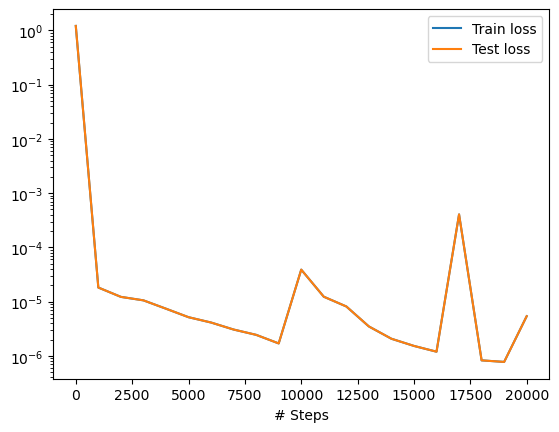

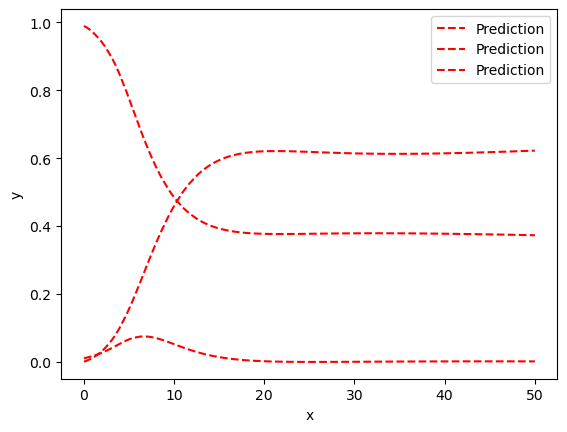

In [6]:

losshistory, train_state = model.train(iterations=20000, model_save_path="../models/sir")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [7]:

model.restore("../models/sir-20000.pt")

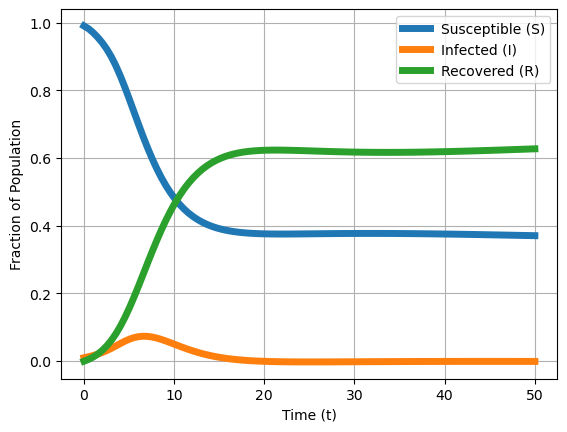

In [8]:
t = np.linspace(t0, tf, 100)
y_pred = model.predict(t.reshape(-1, 1))
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

plt.plot(t, S_pred, label="Susceptible (S)", linewidth=5)
plt.plot(t, I_pred, label="Infected (I)", linewidth=5)
plt.plot(t, R_pred, label="Recovered (R)", linewidth=5)
plt.xlabel("Time (t)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/sir_pinns.pdf")
plt.show()

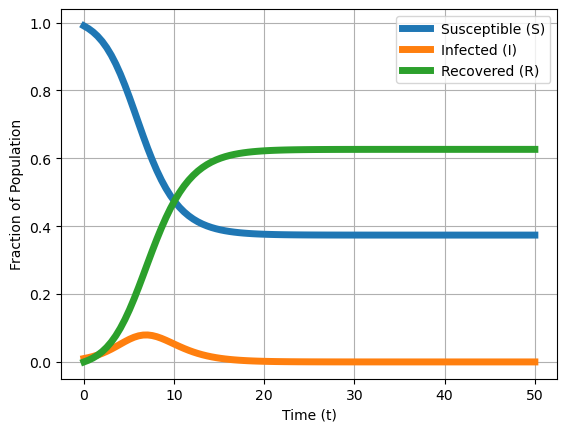

In [9]:
#método Runge Kutta para o modelo SIR

import numpy as np
import matplotlib.pyplot as plt

# Modelo SIR: dS/dt = -β S I, dI/dt = β S I - μ I, dR/dt = μ I
def sir_model(y, t, beta, mu):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - mu * I
    dRdt = mu * I
    return np.array([dSdt, dIdt, dRdt])

# Implementação do método RK4
def rk4(f, y0, t, beta, mu):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        dt = t[i+1] - t[i]
        k1 = f(y[i], t[i], beta, mu)
        k2 = f(y[i] + dt * k1 / 2, t[i] + dt / 2, beta, mu)
        k3 = f(y[i] + dt * k2 / 2, t[i] + dt / 2, beta, mu)
        k4 = f(y[i] + dt * k3, t[i] + dt, beta, mu)
        y[i+1] = y[i] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return y

# Parâmetros do modelo
beta = 1.4    # Taxa de transmissão
mu = 0.9      # Taxa de recuperação

# Condições iniciais
S0, I0, R0 = 0.99, 0.01, 0  # 99% suscetíveis, 1% infectados, 0% recuperados
y0 = np.array([S0, I0, R0])

# Intervalo de tempo
t = np.linspace(0, 50, 100)  # De 0 a 50, com 100 pontos

# Resolver o sistema SIR com RK4
sol = rk4(sir_model, y0, t, beta, mu)

# Separar as soluções
S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]

# Plotar os resultados
plt.plot(t, S, label="Susceptible (S)", linewidth=5)
plt.plot(t, I, label="Infected (I)", linewidth=5)
plt.plot(t, R, label="Recovered (R)", linewidth=5)
plt.xlabel("Time (t)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/sir_rk4.pdf")
plt.show()